# Visible Watermark Information Classification Dataset

## Model Selection w/ Keras Tuner

This notebook demonstrates an attempt to use Keras Tuner together with Keras CV and Tensorflow to perform model selection. Due to resource constraints
a manual approach was required, but this can be used as a reference for future projects where more GPU resources may be available.

In [5]:
import os

import keras
import keras_cv
import tensorflow as tf
import keras_tuner as kt

# project utils
from lib.roboflow_yolov8_loader import RoboflowYOLOv8Loader
from lib.utils import visualize_dataset, view_splits

# Also possible to use jax or pytorch.
os.environ["KERAS_BACKEND"] = "tensorflow"

# attempt to limit memory consumption on the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# Objects/Information we are trying to detect.
# numerical representation is based on list index.
CLASS_IDS = [
    "contact",  # contact information
    "identifier",  # image identifier
    "logo",  # a company logo
    "notice",  # copyright or other type of notice
]

DATA_DIR = "./visible-watermark-detection-VOC2007.v4i.yolov8"

BOUNDING_BOX_FORMAT = "xyxy"
BATCH_SIZE = 2 # also limit batch size to help limit memory consumption.

VALUE_RANGE = (0, 1)


## Load the visual watermark detection data

The `RoboflowYOLOv8Loader` is then used to load and split the data into different sets required in the pipeline.

In [6]:
# construct custom dataset loader.
data_loader = RoboflowYOLOv8Loader(CLASS_IDS, DATA_DIR, batch_size=BATCH_SIZE)

# load dataset.
# split percentage is managed by Roboflow and exported.
train, val, test = data_loader.load_dataset()

# verify split percentage from Roboflow
view_splits(train, val, test)

100%|██████████| 10/10 [00:00<00:00, 5398.77it/s]


         Dataset Splits          
   Split  Percentage
0  train       70.59
1    val       19.61
2   test        9.80


## Data Pre-Processing and Augmentation

Below is the same example of using augmentation for the dataset, shuffling and batching before fine tuning the model.

Augmentation is known to improve accuracy by increasing the size of the dataset dynamically by altering images from the
existing dataset.

In [7]:
augmenters = [
    keras_cv.layers.RandomSaturation(factor=0.1),
    keras_cv.layers.RandomBrightness(factor=0.1),
    keras_cv.layers.RandomContrast(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.RandomHue(factor=0.1, value_range=VALUE_RANGE),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640),
        scale_factor=(0.8, 1.2),
        bounding_box_format=BOUNDING_BOX_FORMAT
    )
]   

def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn

augmenter_fn = create_augmenter_fn(augmenters)


resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format=BOUNDING_BOX_FORMAT, pad_to_aspect_ratio=True
)

def dict_to_tuple(inputs):
    return inputs["images"], keras_cv.bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=30
    )

# load into correct format for the model
train_ds = ( train
                .shuffle(BATCH_SIZE * len(CLASS_IDS))
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

val_ds =   ( val
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

test_ds =  ( test
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=tf.data.AUTOTUNE)
                .map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
                .prefetch(tf.data.AUTOTUNE)
           )

TRAINING DATA


2025-03-22 10:22:08.125583: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 924217659225135821
2025-03-22 10:22:08.125670: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3116943555277667657
2025-03-22 10:22:08.165632: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: CANCELLED: Loop execution was cancelled.
	 [[{{node jittered_resize_1_1/map/while/LoopCond/_16}}]]


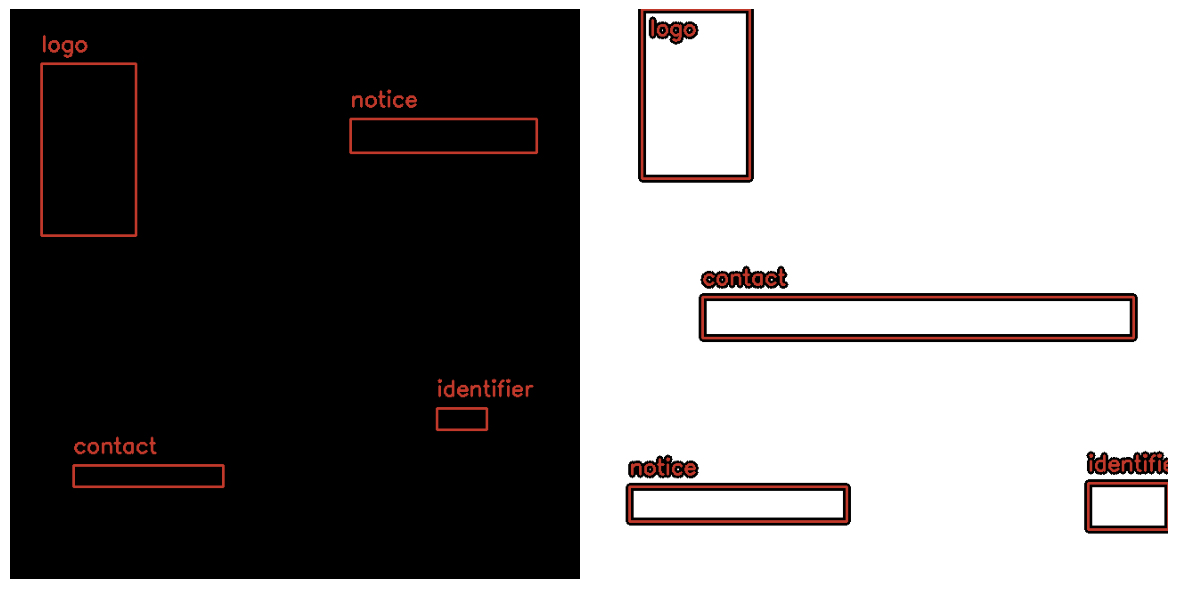

In [8]:
# visualize the training split.
print("TRAINING DATA")
visualize_dataset(
    train_ds,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT, 
    rows=1, 
    cols=2, 
)

VALIDATION DATA


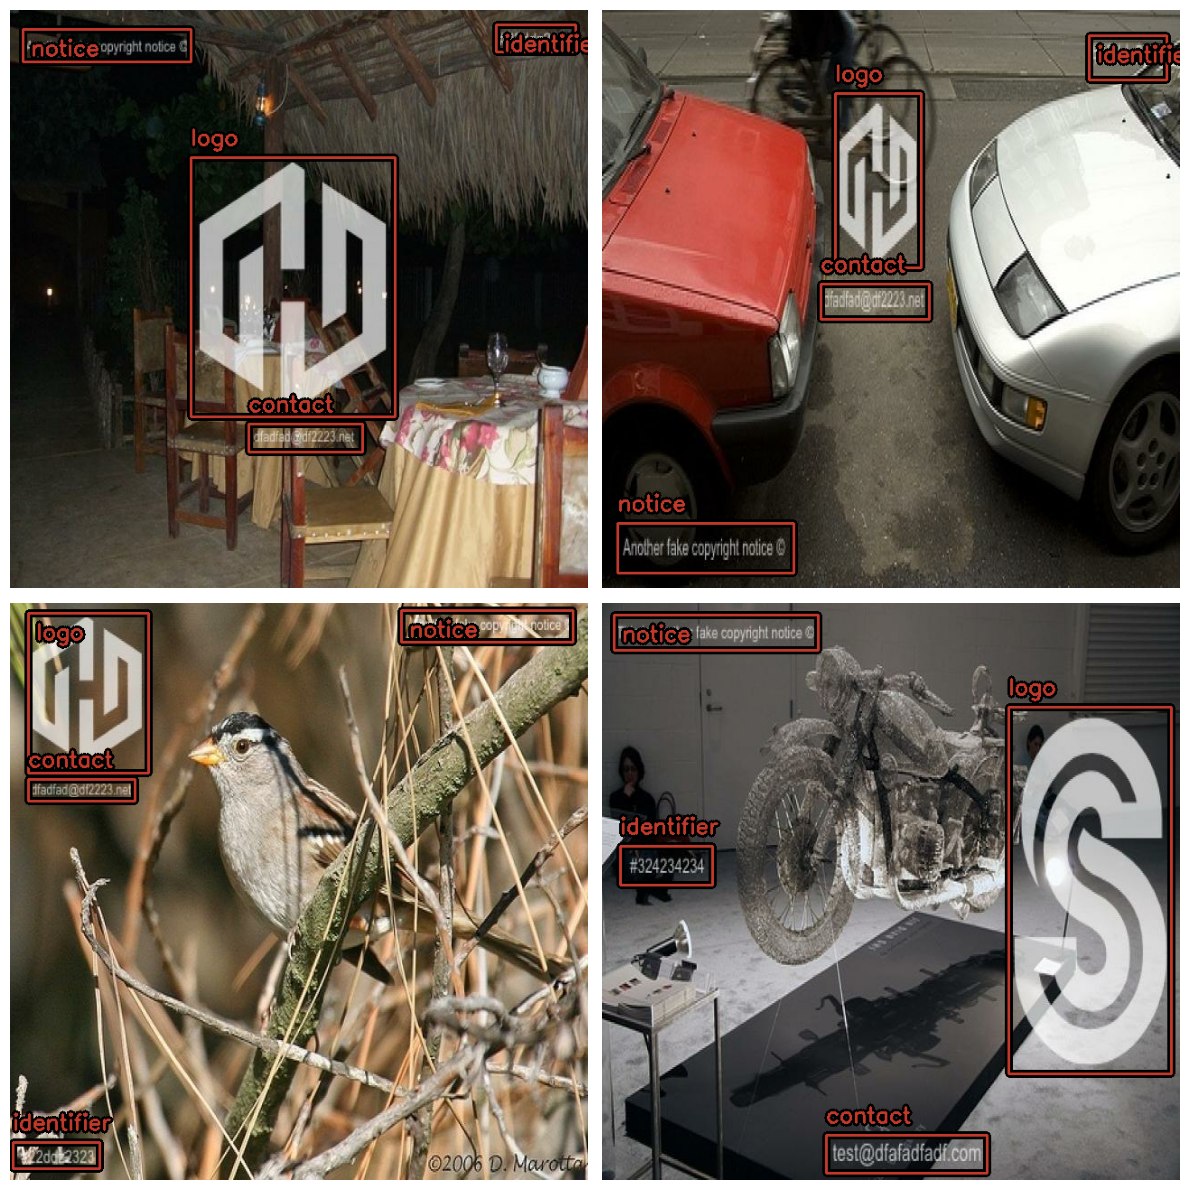

In [ ]:
print("VALIDATION DATA")
visualize_dataset(
    val_ds,
    data_loader.class_mapping,
    bounding_box_format=BOUNDING_BOX_FORMAT,
    value_range=(0, 255),
    rows=2,
    cols=2,
)

# Yolo V8 Hyper Model

The hypermodel is what is used to define the search space to use for model selection and hyper parameter tuning/optimization. 

In the example below, I select different model architectures (backbones, optimizers, loss functions etc.) as well as their associated hyperparameters.

Defining the model and the choices to be taken defines the search space that will be used to selection/optimization.

In [ ]:
class YOLOV8DetectorHyperModel(kt.HyperModel):

    def build(self, hp: kt.HyperParameters) -> keras_cv.models.YOLOV8Detector:
        '''build_model uses the HyperParameters class to define
        the search space for model selection using KerasTuner.

        Args:
            hp (kt.HyperParameters): hyper parameters object for searching.

        Returns:
            keras.Sequential: the Sequential model to use for searching.
        '''

        fpn_depth = hp.Choice("fpn_depth", [1, 2, 3])

        prediction_decoder=keras_cv.layers.NonMaxSuppression(
            bounding_box_format=BOUNDING_BOX_FORMAT,
            from_logits=hp.Choice("from_logits", [True, False]),
            confidence_threshold=hp.Choice("confidence_threshold", [0.4, 0.5, 0.75, 0.90]),
            iou_threshold=hp.Choice("iou_threshold", [0.1, 0.4, 0.5, 0.75])
        )

        backbone = hp.Choice(
            "backbone",
            [
                "yolo_v8_xs_backbone_coco",
                "yolo_v8_s_backbone_coco",
            ],
        )

        model = keras_cv.models.YOLOV8Detector(
            backbone=keras_cv.models.YOLOV8Backbone.from_preset(backbone, load_weights=True),
            num_classes=len(CLASS_IDS),
            fpn_depth=fpn_depth,
            prediction_decoder=prediction_decoder,
            bounding_box_format=BOUNDING_BOX_FORMAT,
        )

        # Classification loss settings
        classification_loss_mapping = {
            "categorical_crossentropy": keras.losses.CategoricalCrossentropy(),
            "categorical_focal_crossentropy": keras.losses.CategoricalFocalCrossentropy(),
        }

        classification_loss = hp.Choice(
            "classification_loss",
            [   
                "categorical_crossentropy",
                "categorical_focal_crossentropy"
            ],
        )

        # Optimizer settings
        initial_learning_rate = 0.01
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate,
            decay_steps=1000,
            alpha=0.0
        )

        global_clipnorm = hp.Choice("global_clipnorm", [8.0, 9.0, 10.0])
        weight_decay = hp.Choice("weight_decay", [1e-4, 1e-5, 1e-6])
        momentum = hp.Choice("momentum", [0.7, 0.85, 0.95])

        optimizer_mapping = {
            "adam": keras.optimizers.Adam(
                learning_rate=lr_schedule,
                global_clipnorm=global_clipnorm,
                weight_decay=weight_decay
            ),
            "rmsprop": keras.optimizers.RMSprop(
                learning_rate=lr_schedule,
                global_clipnorm=global_clipnorm,
                weight_decay=weight_decay,
                momentum=momentum
            ),
            "sgd": keras.optimizers.SGD(  
                learning_rate=lr_schedule,
                global_clipnorm=global_clipnorm,
                weight_decay=weight_decay,
                momentum=momentum 
            ),
        }

        optimizer = hp.Choice(
            "optimizer", [
                "adam", "rmsprop", "sgd"
            ],
        )

        # box loss settings
        box_loss_mapping = {
            "ciou": keras_cv.losses.CIoULoss(bounding_box_format=BOUNDING_BOX_FORMAT),
            "giou": keras_cv.losses.GIoULoss(bounding_box_format=BOUNDING_BOX_FORMAT),
        }

        box_loss = hp.Choice(
            "box_loss", [
                "ciou", "giou"
            ],
        )


        # compile with selections
        model.compile(
            classification_loss=classification_loss_mapping[classification_loss],
            box_loss=box_loss_mapping[box_loss],
            optimizer=optimizer_mapping[optimizer],
        )

        return model

# Using RandomSearch is a good starting point for projects with limited time / resources
# as it will randomly select values from the search space.  For more systematic search,
# the GridSearch can be used to search all possible combinations.
tuner = kt.RandomSearch(
    hypermodel=YOLOV8DetectorHyperModel(),
    objective="val_loss",           # Unable to use PyCOCO metrics as objective due to copy issue. :(
    max_trials=15,  # search at most 25 different sets of hyperparameters.
    executions_per_trial=2, # train 2 times per set of hyperparams.
    overwrite=True,
    directory="./model_selection/random_search",
    project_name="yolov8",
)

# show search space based on hyperparameter combinations we are testing.
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 11
fpn_depth (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
from_logits (Choice)
{'default': 1, 'conditions': [], 'values': [1, 0], 'ordered': True}
confidence_threshold (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.4, 0.5, 0.75, 0.9], 'ordered': True}
iou_threshold (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.4, 0.5, 0.75], 'ordered': True}
backbone (Choice)
{'default': 'yolo_v8_xs_backbone_coco', 'conditions': [], 'values': ['yolo_v8_xs_backbone_coco', 'yolo_v8_s_backbone_coco'], 'ordered': False}
classification_loss (Choice)
{'default': 'categorical_crossentropy', 'conditions': [], 'values': ['categorical_crossentropy', 'categorical_focal_crossentropy'], 'ordered': False}
global_clipnorm (Choice)
{'default': 8.0, 'conditions': [], 'values': [8.0, 9.0, 10.0], 'ordered': True}
weight_decay (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 1e-05, 1e-06], 'ordered

In [ ]:
# perform random search over the hyperparameter search space.
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=50,    # set max number of epochs, will be stopped by EarlyStopping callback.
    callbacks=[
        keras.callbacks.TensorBoard(log_dir="./model_selection/training_logs"),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,  # Stop after 5 epochs if no improvement
            verbose=0,
        ),
    ],
    verbose=0,
)

# # view summary of top 3 trials. Restricted to limit report length.
tuner.results_summary(num_trials=3)

top_models = tuner.get_best_models(num_models=5)
top_hyperparameters = tuner.get_best_hyperparameters(num_trials=5)

top_model = top_models[0].build(top_hyperparameters[0])

top_model.summary()

/home/gb/FinalProject/iteration3/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(4, 640, 640, 3))
  warnings.warn(msg)
I0000 00:00:1739396918.784421    2497 service.cc:148] XLA service 0x7f3c500020b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739396918.790193    2497 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2025-02-12 16:48:40.848452: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739396923.623047    2497 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-12 16:48:47.333472: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.30GiB 

# References

[1] Team, Keras. “Keras Documentation: Efficient Object Detection with YOLOV8 and KerasCV.” Keras.io, keras.io/examples/vision/yolov8/.

[2] K. Team, “Keras documentation: Keras API reference” Keras.io. https://keras.io/api/

[3] K. Team, "Keras Tuner: Getting Started" Keras.io. https://keras.io/keras_tuner/getting_started/
‌